# Audio Analysis - HP Unlocked Challenge 3
This project is part of the **[HP Z Challenge](https://www.hp.com/us-en/workstations/industries/data-science/unlocked-challenge.html)**, specifically **Challenge #3**, which involves training a model to recognize the calls of the Capuchinbird. The goal is to develop a classifier that can detect these bird calls within long forest recordings, providing insight into when and where the bird appears most frequently.

The project is based on multiple sources:
- The **[PyTorch Speech Command Recognition Tutorial](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio_tutorial.html)**, which introduces key concepts in audio classification.
- **Previous research and coursework**, integrating elements from past implementations.

## Project Structure
The project is divided into two main parts:

1. **Part 1: Capuchinbird Classifier**  
   - **Dataset Initialisation**: Loading and processing audio files.
   - **Model Architecture**: Constructing a neural network to classify Capuchinbird calls.  
   - **Training & Evaluation**: Training the model on labeled data and assessing its performance.  

   The **core idea** is to convert audio files into **spectrograms**, treating them as images. This allows the model to leverage **convolutional neural networks (CNNs)** for feature extraction.

2. **Part 2: Capuchinbird Event Detection**  
   - The long **audio recordings** (3min) are divided into smaller **segments** (3sec).  
   - Each segment is passed through the trained classifier.  
   - The model determines whether a Capuchinbird call is present and records the corresponding timestamps.  

# Part 1 - Capuchinbird Classificator

## Initiliasation

In [1]:
# Import packages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as transforms
import torchaudio
import os
import numpy
import random
import matplotlib.pyplot as plt

from IPython.display import Audio, display
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


## Testing Audio File Loading and Visualization

This block is used to test whether the audio data can be successfully loaded and displayed. It reads an available file from each of the given directories.

For each file, the script:
1. Loads the audio using `torchaudio.load()`.
2. Prints basic information, such as waveform shape and sample rate.
3. Plots the waveform to visualize the signal.
4. Optionally displays an audio player for playback.

This test **is not required for the final model** but can be run optionally to verify that the dataset is correctly formatted and accessible.


File: ./data/Forest Recordings/recording_92.mp3
Waveform shape: torch.Size([2, 8642000])
Sample rate: 48000


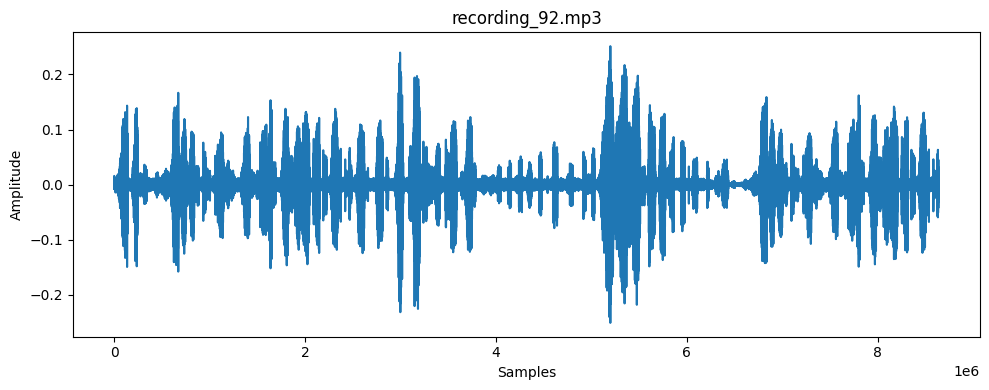


File: ./data/Parsed_Capuchinbird_Clips/XC395129-3.wav
Waveform shape: torch.Size([2, 110250])
Sample rate: 44100


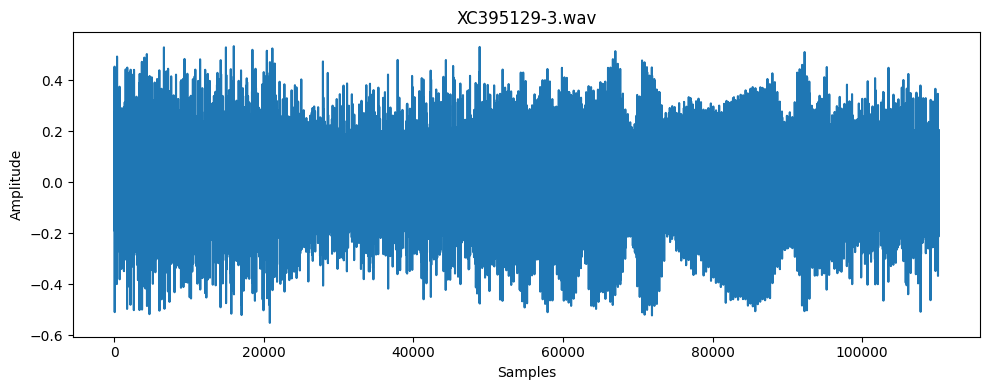


File: ./data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-5.wav
Waveform shape: torch.Size([2, 134858])
Sample rate: 44100


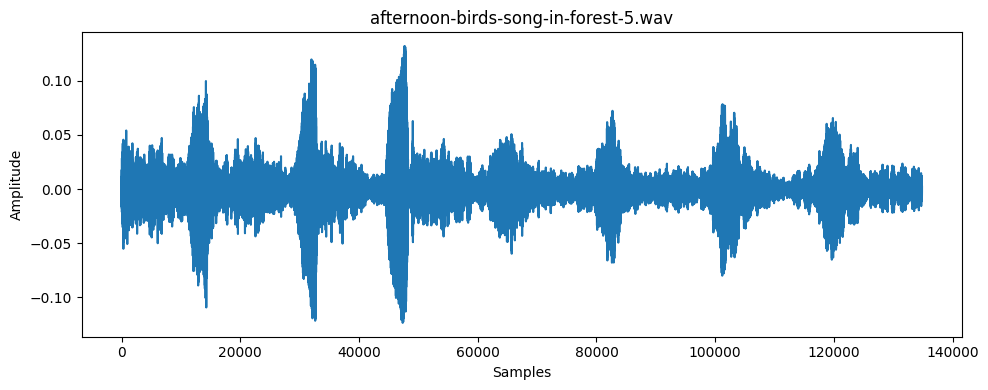

In [3]:
# Paths to subdirectories
base_path = "./data"
forest_dir = os.path.join(base_path, "Forest Recordings")
capuchin_dir = os.path.join(base_path, "Parsed_Capuchinbird_Clips")
not_capuchin_dir = os.path.join(base_path, "Parsed_Not_Capuchinbird_Clips")

def load_and_plot(filepath, play_audio=True):
    """
    Loads an audio file, prints basic info, plots the waveform,
    and optionally displays an audio player for playback.
    """
    try:
        waveform, sample_rate = torchaudio.load(filepath)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return

    print(f"\nFile: {filepath}")
    print(f"Waveform shape: {waveform.shape}")
    print(f"Sample rate: {sample_rate}")

    # If stereo, convert to mono by averaging channels
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)
    
    # Plotten des Waveforms (kanalweise)
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title(os.path.basename(filepath))
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    if play_audio:
        display(Audio(filepath))

def get_first_file(directory, extension):
    """
    Finds a file in a directory with the specified extension.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(extension)]
    if not files:
        print(f"No files with extension {extension} found in {directory}.")
        return None
    return files[0]

# Test: Load one file from each directory
forest_file = get_first_file(forest_dir, ".mp3")
capuchin_file = get_first_file(capuchin_dir, ".wav")
not_capuchin_file = get_first_file(not_capuchin_dir, ".wav")

if forest_file:
    load_and_plot(forest_file)
if capuchin_file:
    load_and_plot(capuchin_file)
if not_capuchin_file:
    load_and_plot(not_capuchin_file)

## Initialise dataset

The workflow uses a structured method to transform raw audio files into spectrograms suitable for the following model. The following steps outline this approach:

1. **Collecting File Paths:**
   - Identify and store the paths of all relevant audio files.

2. **Waveform Preparation:**
   - Convert stereo audio to mono if necessary.
   - Resample audio to a consistent sample rate.
   - Normalize amplitudes for a more uniform scale.

3. **Mel-Spectrogram Conversion:**
   - Generate a [**Mel-spectrogram**](https://pytorch.org/audio/main/generated/torchaudio.transforms.MelSpectrogram.html) from the waveform.
   - Apply **padding or interpolation** so that all spectrograms have the same size (e.g., 64 frequency bins × 200 time frames).

4. **Dataset and DataLoader:**
   - Use a custom dataset class that loads and processes each file on demand.

### Why Use Spectrograms

Audio is often stored as waveforms in the time domain, showing how amplitude changes over time. But: Waveform do not directly show how different frequencies vary over time. A **spectrogram** addresses this by representing sound in the **time–frequency domain**.

Since a spectrogram can be viewed as a **two-dimensional image**, methods from image processing, such as CNNs, can analyze it effectively. This approach makes it easier to detect patterns in audio signals.



### Helper Functions

In [8]:
def get_first_file(directory, extension):
    """
    Finds a file in a directory with the specified extension.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(extension)]
    if not files:
        print(f"No files with extension {extension} found in {directory}.")
        return None
    return files[0]

def get_files(directory, extension=".wav"):
    """
    Returns a list of all files in a directory with the specified extension.
    :param directory: The directory path to search for files.
    :param extension: File extension (default ".wav")
    :return: A list of file paths matching the given extension, or an empty list if none are found.
    """
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist.")
        return []
    
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(extension)]
    
    if not files:
        print(f"No files with extension {extension} found in {directory}.")
        
    return files

def initialise_datasets():
    """
    Gathers all audio files from folders, then splits them into
    train and test sets.

    :return: Two lists containing file paths for training and test sets.
    """

    # Paths to subdirectories
    base_path = "./data"
    capuchin_dir = os.path.join(base_path, "Parsed_Capuchinbird_Clips")
    not_capuchin_dir = os.path.join(base_path, "Parsed_Not_Capuchinbird_Clips")

    # Gather files
    capuchin_files = get_files(capuchin_dir)
    not_capuchin_files = get_files(not_capuchin_dir)

    # Combine them
    all_files = capuchin_files + not_capuchin_files

    # Shuffle for randomness
    random.shuffle(all_files)

    # Split: 80% train, 20% test
    num_total = len(all_files)
    train_end = int(num_total * 0.80)

    train_files = all_files[:train_end]
    test_files = all_files[train_end:]

    print(f"Total files: {num_total}")
    print(f"Train: {len(train_files)}, Test: {len(test_files)}")

    return train_files, test_files

def process_audio(file_path, target_sample_rate=44100, n_mels=64, fixed_time_frames=200):
    """
    Loads an audio file, converts to mono, resamples, and creates a fixed-size Mel-Spectrogram.
    
    :param file_path: Path to the audio file.
    :param target_sample_rate: Resample rate (default = 22050).
    :param n_mels: Number of Mel frequency bins (height of the spectrogram).
    :param fixed_time_frames: Width of the spectrogram (number of time frames).
    :return: Mel-Spectrogram tensor of shape [1, n_mels, fixed_time_frames].
    """
    debug = False
    
    # 1) Load audio
    waveform, sample_rate = torchaudio.load(file_path)
    if debug: print(f"Waveform Shape (after Step 1): {waveform.shape}")
    
    # Check if waveform is empty
    if waveform.shape[1] == 0:
        print(f"Warning: Empty audio file {file_path}")
        return torch.zeros(1, n_mels, fixed_time_frames)  # Return empty spectrogram
    
    # 2) Convert Stereo to Mono if needed
    # [2, Samples] -> [1, Samples]
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)
        waveform = waveform.unsqueeze(0)

    if debug: print(f"Waveform Shape (after Step 2): {waveform.shape}")

    # 3) Resample to target_sample_rate
    if sample_rate != target_sample_rate:
        resampler = transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    if debug: print(f"Waveform Shape (after Step 3): {waveform.shape}")
    
    # 4) Normalize
    waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)

    if debug: print(f"Waveform Shape (after Step 4): {waveform.shape}")

    # Ensure waveform has enough samples for MelSpectrogram
    # Sort out files shorter than 2sec (44100Hz * 2)
    if waveform.shape[1] < 88200:
        print(f"Warning: Audio file {file_path} has too few samples")
        return torch.zeros(1, n_mels, fixed_time_frames)

    # 5) Convert to Mel-Spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=target_sample_rate,
        n_mels=n_mels
    )
    mel_spec = mel_transform(waveform)  # shape: [1, n_mels, time]

    if debug: print(f"mel_spec Shape (after Step 5): {mel_spec.shape}")

    # Check mel_spec dimensions before accessing shape[2]
    if mel_spec.shape[0] != 1 or mel_spec.shape[1] != n_mels:
        print(f"Warning: Invalid Mel-Spectrogram shape for {file_path} -> {mel_spec.shape}")
        return torch.zeros(1, n_mels, fixed_time_frames)

    # 6) Fix the time dimension (padding/truncation)
    current_time_frames = mel_spec.shape[2]

    if current_time_frames < fixed_time_frames:
        # Pad with zeros
        pad_total = fixed_time_frames - current_time_frames
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        mel_spec = F.pad(mel_spec, (pad_left, pad_right))
    elif current_time_frames > fixed_time_frames:
        mel_spec = mel_spec.unsqueeze(1) # [N, W, H] -> [N, 1, W, H]
        mel_spec = F.interpolate(mel_spec, size=(n_mels, fixed_time_frames), mode="bilinear", align_corners=False) # expects [N, C, W, H]
        mel_spec = mel_spec.squeeze(1) # [N, 1, W, H] -> [N, W, H]

    # Final shape: [1, n_mels, fixed_time_frames]
    return mel_spec

### Create Dataset Class

In [9]:
class AudioDataset(Dataset):
    def __init__(self, file_list, target_sample_rate=44100, n_mels=64, fixed_time_frames=200):
        """
        Custom Dataset for transforming audio files into Mel-Spectrograms.
        
        :param file_list: List of audio file paths.
        :param target_sample_rate: Resample rate.
        :param n_mels: Number of Mel frequency bins.
        :param fixed_time_frames: Fixed number of time frames for uniform spectrogram size.
        """
        self.file_list = file_list
        self.target_sample_rate = target_sample_rate
        self.n_mels = n_mels
        self.fixed_time_frames = fixed_time_frames

        # Precompute labels so __getitem__ ist faster
        self.labels = []
        for file_path in self.file_list:
            # If the folder name 'Parsed_Capuchinbird_Clips' is in the path -> label=1
            if "Parsed_Capuchinbird_Clips" in file_path:
                self.labels.append(1)
            else:
                # Otherwise it must be from the Not_Capuchinbird folder -> label=0
                self.labels.append(0)
        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx] # 1 (Capuchin) or 0 (Not Capuchin)
        
        mel_spec = process_audio(
            file_path,
            target_sample_rate=self.target_sample_rate,
            n_mels=self.n_mels,
            fixed_time_frames=self.fixed_time_frames
        )

        # Ensure correct dtype for loss function
        label = torch.tensor(label, dtype=torch.float32)
        
        # Return Mel-Spectrogram
        return mel_spec, label

### Build dataset

In [12]:
def check_sample_rates(file_list):
    sample_rates = set()
    for file_path in file_list:
        waveform, sample_rate = torchaudio.load(file_path)
        sample_rates.add(sample_rate)
    
    print(f"Unique sample rates in dataset: {sample_rates}")

# Check the sample rates of training and test (unique values)
check_sample_rates(train_files + test_files)


Unique sample rates in dataset: {48000, 11025, 44100}


In [11]:
# Initialise dataset as lists with pathes
train_files, test_files = initialise_datasets()

# Create dataset instances
train_dataset = AudioDataset(train_files)
test_dataset = AudioDataset(test_files)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Get a batch of data
mel_specs, labels = next(iter(train_loader))

print(f"Mel-Specs shape: {mel_specs.shape}")   # Expected: (batch_size, 1, 64, 200)
print(f"Labels shape: {len(labels)}")          # Expected: batch_size

Total files: 810
Train: 648, Test: 162
Mel-Specs shape: torch.Size([16, 1, 64, 200])
Labels shape: 16


### Testing

#### Load File and generate Spectrogram


File: ./data/Parsed_Capuchinbird_Clips/XC395129-3.wav
Waveform shape: torch.Size([2, 110250])
Sample rate: 44100


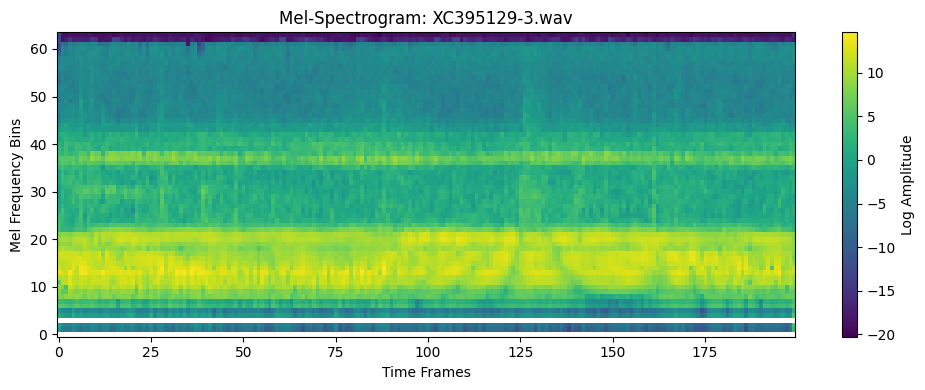


File: ./data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-5.wav
Waveform shape: torch.Size([2, 134858])
Sample rate: 44100


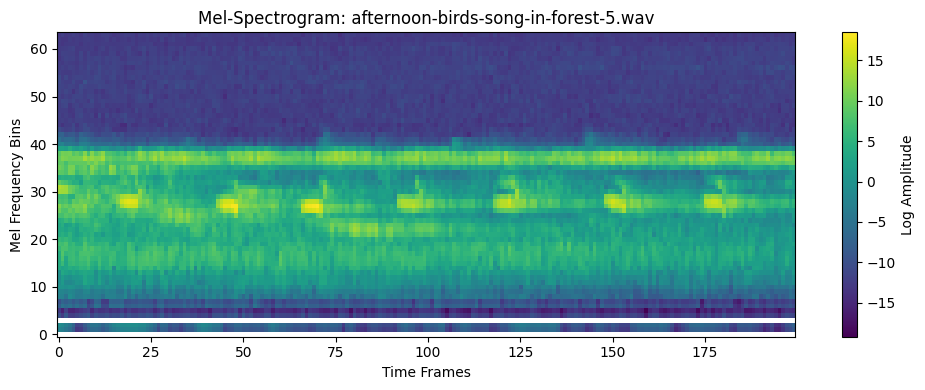

In [13]:
def load_and_show_spectrogram(filepath, play_audio=True):
    """
    Loads an audio file, prints basic info, displays its Mel-Spectrogram,
    and optionally provides an audio player.

    :param filepath: Path to the audio file.
    :param play_audio: If True, display an audio player.
    :param n_mels: Number of mel-frequency bins for the spectrogram.
    """
    try:
        waveform, sample_rate = torchaudio.load(filepath)
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return

    print(f"\nFile: {filepath}")
    print(f"Waveform shape: {waveform.shape}")
    print(f"Sample rate: {sample_rate}")

    mel_spec = process_audio(filepath)  # shape: [1, n_mels, time]

    # Plot the Mel-Spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec[0].log2().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Mel-Spectrogram: {os.path.basename(filepath)}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label='Log Amplitude')
    plt.tight_layout()
    plt.show()

    # Optional: play audio
    if play_audio:
        display(Audio(filepath))

# Example usage:
base_path = "./data"
capuchin_file = get_first_file(capuchin_dir, ".wav")
not_capuchin_file = get_first_file(not_capuchin_dir, ".wav")

if capuchin_file:
    load_and_show_spectrogram(capuchin_file)

if not_capuchin_file:
    load_and_show_spectrogram(not_capuchin_file)

#### Visualize Spectrogram from Batch

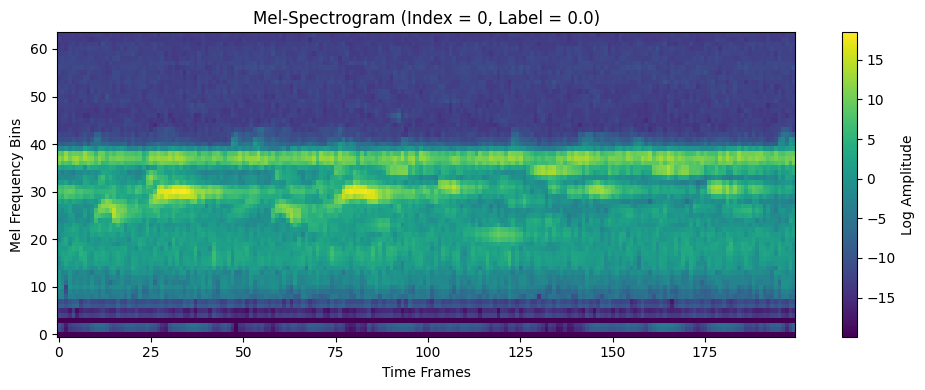

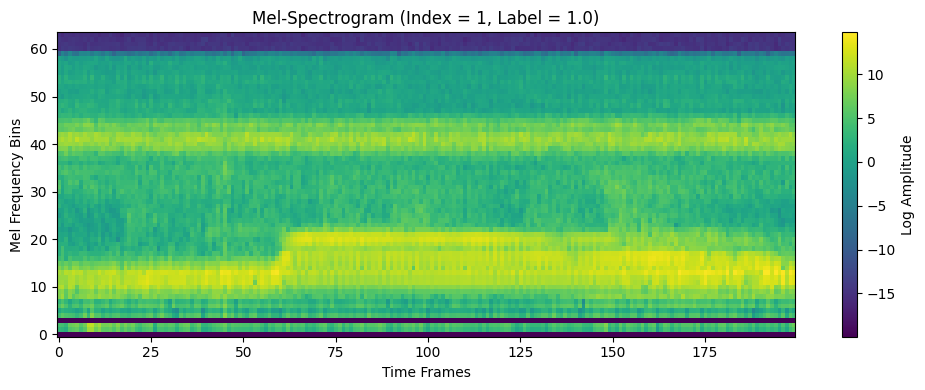

In [14]:
def show_spectrogram_from_batch(mel_specs, labels, idx):
    """
    Displays a single spectrogram from a batch.

    :param mel_specs: Tensor (List of Mel-Spectrograms)
    :param labels: Tensor (Labels for each spectrogram)
    :param idx: Index of the item in the batch to be displayed
    """
    try:
        # Ensure the tensor is on the CPU for visualization
        spec = mel_specs[idx].detach().cpu()  # Shape: [1, freq_bins, time_frames]
        label = labels[idx].detach().cpu().item()  # Convert tensor to integer

        # Remove the channel dimension
        spec = spec.squeeze()  # Shape: [freq_bins, time_frames]

        # Transform
        spec = torch.log2(spec + 1e-6)

        # Plot
        plt.figure(figsize=(10, 4))
        plt.imshow(spec.numpy(), origin='lower', aspect='auto', cmap='viridis')
        plt.title(f"Mel-Spectrogram (Index = {idx}, Label = {label})")
        plt.xlabel("Time Frames")
        plt.ylabel("Mel Frequency Bins")
        plt.colorbar(label='Log Amplitude')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error displaying spectrogram: {e}")

# Show spectrograms
mel_specs, labels = next(iter(train_loader))  # Fetch a batch
show_spectrogram_from_batch(mel_specs, labels, idx=0)  # Display first spectrogram
show_spectrogram_from_batch(mel_specs, labels, idx=1)  # Display second spectrogram

## Define Network

In [35]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) # [32,64,200]
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4) # [32,16,50]

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # [64,16,50]
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4) # [64,4,12]

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 12, 64)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Drops elements with 50% probability
        self.fc2 = nn.Linear(64, 1) # Output 1 value for binary classification

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the CNN model
cnn_model = CNNClassifier()

# Print the model to confirm setup
print(cnn_model)

# Function to count the parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count and print the number of parameters
cnn_parameters = count_parameters(cnn_model)
print(f"Number of trainable parameters: {cnn_parameters}")

CNNClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
Number of trainable parameters: 216065


### Loss and Optimizer

In [36]:
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Get a batch of training data
mel_specs, labels = next(iter(train_loader))
outputs = cnn_model(mel_specs)

# Compute the loss
loss = criterion(outputs.squeeze(), labels)
print(f"Binary Cross-Entropy Loss: {loss.item()}")

Binary Cross-Entropy Loss: 529.3651733398438


## Training

In [37]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0

    progress_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch+1}/{num_epochs}"
    )

    for batch_idx, (mel_specs, labels) in progress_bar:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(mel_specs) # [batch_size, 1]

        # Compute the loss
        loss = criterion(outputs.squeeze(), labels) # squeeze() -> [batch_size]

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {running_loss/len(train_loader):.4f}")
    
print("Training complete!")


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:11<00:00,  3.63it/s, loss=0]


Epoch 1/5, Average Loss: 133.2423


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  4.00it/s, loss=9.95e-7]


Epoch 2/5, Average Loss: 4.0971


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  3.82it/s, loss=0.281]


Epoch 3/5, Average Loss: 1.5065


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  3.99it/s, loss=0.00341]


Epoch 4/5, Average Loss: 0.3374


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  3.97it/s, loss=0.174]

Epoch 5/5, Average Loss: 0.7686
Training complete!


## Evaluation

In [40]:
# Load Model Weights
cnn_model.load_state_dict(torch.load("model-DATE-TIME.pth"))

<All keys matched successfully>

In [38]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for mel_specs, labels in test_loader:
            outputs = model(mel_specs)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            probs = torch.sigmoid(outputs.squeeze())
            preds = (probs > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    return avg_test_loss, test_accuracy

# After Training:
test_loss, test_acc = test_model(cnn_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.5047, Test Accuracy: 0.9136


In [39]:
# Save Model Weights
torch.save(cnn_model.state_dict(), "model-DATE-TIME.pth")

# Part 2 - Capuchinbird Counter

## Overview
After training the classifier, the next step is to apply it to long **forest recordings** to detect instances of **Capuchinbird calls**. This is done using the `detect_bird_events` method, which processes the recordings and identifies potential bird call events.

## Methodology

1. **Loading the Forest Recordings**  
   - Collect and preprocess the forest audio files.  

2. **Preprocessing & Segmentation**  
   - The sample rate of the forest recordings is **adjusted** to match the sample rate expected by the model.  
   - The audio file is divided into **smaller segments** to ensure the model can effectively analyze each portion.

3. **Bird Event Detection**  
   - Each segment is passed through the trained model.  
   - A **probability threshold of 0.9** is applied to reduce noise and avoid false positives.  
   - If a segment exceeds this probability threshold, it is **considered an event**, and its corresponding **timestamp and probability** are recorded.

4. **Event Clustering**  
   - Since a single Capuchinbird call may be detected in overlapping segments, **clustering** is applied to group related detections.  
   - The final output provides:  
     - **Start and end time of each detected cluster**  
     - **Probability of the cluster occurrence**  

### Output
TODO: The final result is a **structured list of detected Capuchinbird calls**, showing where in the recordings the bird was most likely present.

---


In [41]:
def process_segment(waveform, target_sample_rate=44100, n_mels=64, fixed_time_frames=200):
    """
    Gets an audio segment (waveform), converts to mono, resamples, and converts it into a fixed-size Mel-Spectrogram.
    
    :param file: Path to the audio file.
    :param target_sample_rate: Resample rate (default = 44100).
    :param n_mels: Number of Mel frequency bins (height of the spectrogram).
    :param fixed_time_frames: Width of the spectrogram (number of time frames).
    :return: Mel-Spectrogram tensor of shape [1, n_mels, fixed_time_frames].
    """
    debug = False
        
    # Check if waveform is empty
    if waveform.shape[1] == 0:
        print(f"Warning: Empty audio segment")
        return torch.zeros(1, n_mels, fixed_time_frames)  # Return empty spectrogram
    
    # 4) Normalize
    waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-9)

    # Ensure waveform has enough samples for MelSpectrogram
    if waveform.shape[1] < 88200:
        print(f"Warning: Audio segment has too few samples")
        return torch.zeros(1, n_mels, fixed_time_frames)

    # 5) Convert to Mel-Spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=target_sample_rate,
        n_mels=n_mels
    )
    mel_spec = mel_transform(waveform)  # shape: [1, n_mels, time]

    # Check mel_spec dimensions before accessing shape[2]
    if mel_spec.shape[0] != 1 or mel_spec.shape[1] != n_mels:
        print(f"Warning: Invalid Mel-Spectrogram shape for {file_path} -> {mel_spec.shape}")
        return torch.zeros(1, n_mels, fixed_time_frames)

    # 6) Fix the time dimension (padding/truncation)
    current_time_frames = mel_spec.shape[2]

    if current_time_frames < fixed_time_frames:
        # Pad with zeros
        pad_total = fixed_time_frames - current_time_frames
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        mel_spec = F.pad(mel_spec, (pad_left, pad_right))
    elif current_time_frames > fixed_time_frames:
        mel_spec = mel_spec.unsqueeze(1) # [N, W, H] -> [N, 1, W, H]
        mel_spec = F.interpolate(mel_spec, size=(n_mels, fixed_time_frames), mode="bilinear", align_corners=False) # expects [N, C, W, H]
        mel_spec = mel_spec.squeeze(1) # [N, 1, W, H] -> [N, W, H]

    # Final shape: [1, n_mels, fixed_time_frames]
    return mel_spec

In [42]:
def cluster_bird_events(detections, gap=5):
    """
    Clusters detections if they are closer than `gap` seconds.
    :param detections: list of bird events
    :param gap: maximum allowed gap in seconds to be considered 'one event'
    :return: list of clusters
    """
    
    if not detections:
        print("No bird events found.")
        return []
        
    # Sort by time
    detections = sorted(detections, key=lambda x: x[0])

    clusters = []
    # Init first cluster
    current_cluster = {
        "start": detections[0][0],
        "end": detections[0][0],
        "max_prob": detections[0][1],
        "count": 1
    }

    for i in range(1, len(detections)):
        timestamp, prob = detections[i]
        # If (event-time delta <= gap): add to count
        if timestamp - current_cluster["end"] <= gap:
            current_cluster["end"] = timestamp
            current_cluster["max_prob"] = max(current_cluster["max_prob"], prob)
            current_cluster["count"] += 1
        else:
            # If not: create new cluster
            clusters.append(current_cluster)
            current_cluster = {
                "start": timestamp,
                "end": timestamp,
                "max_prob": prob,
                "count": 1
            }

    # Letzten Cluster noch hinzufügen
    clusters.append(current_cluster)
    return clusters

def detect_bird_events(audio_path, model, window_size=3, step_size=0.5, sample_rate=44100):
    """
    Slides a window over the audio and checks for bird presence in each segment.
    :param audio_path: Path to the longer audio (3 min).
    :param model: Trained CNN model (in eval mode).
    :param window_size: Length of each segment in seconds (3s).
    :param step_size: Step to move the window in seconds.
    :param sample_rate: Sample rate should match with model.
    :return: A list of timestamps where the model predicts bird presence.
    """
    # Load Forest Audio
    waveform, sr = torchaudio.load(audio_path)
    
    # Resample if sr != sample_rate
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)
        sr = sample_rate

    # Convert stereo to mono if needed
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Create segments
    segment_samples = int(window_size * sr)
    step_samples = int(step_size * sr)

    total_samples = waveform.shape[1] # total length
    positions = []
    
    start = 0
    while start + segment_samples <= total_samples:
        segment = waveform[:, start:start+segment_samples]  # [1, segment_samples]
        
        # eature Extraction (Mel-Spec)
        mel_spec = process_segment(segment)  # [1, n_mels, time_frames]
        
        with torch.no_grad():
            # Add batch dimension
            mel_spec = mel_spec.unsqueeze(0)
            output = model(mel_spec)
            prob = torch.sigmoid(output).item() 

        # Threshold
        if prob > 0.9:
            time_in_sec = start / sr
            positions.append((time_in_sec, prob))  # Timestamp and Probability

        start += step_samples

    return positions


cnn_model.eval()

# Gather files
base_path = "./data"
forest_dir = os.path.join(base_path, "Forest Recordings")
forest_files = get_files(forest_dir, ".mp3")

# Count Events
print(f"Checking file {forest_files[1]}")
bird_events = detect_bird_events(forest_files[1], cnn_model)

# Print clustered events
bird_events_cluster = cluster_bird_events(bird_events)
for c in bird_events_cluster:
    print(f"Detected Bird at {c}")


Checking file ./data/Forest Recordings/recording_71.mp3
Detected Bird at {'start': 8.5, 'end': 14.5, 'max_prob': 1.0, 'count': 6}
Detected Bird at {'start': 27.5, 'end': 31.0, 'max_prob': 1.0, 'count': 6}
Detected Bird at {'start': 44.0, 'end': 44.0, 'max_prob': 0.9768820405006409, 'count': 1}
Detected Bird at {'start': 57.5, 'end': 60.0, 'max_prob': 1.0, 'count': 4}
Detected Bird at {'start': 66.5, 'end': 70.5, 'max_prob': 1.0, 'count': 7}
Detected Bird at {'start': 86.0, 'end': 90.0, 'max_prob': 1.0, 'count': 7}
Detected Bird at {'start': 100.0, 'end': 100.5, 'max_prob': 0.9999998807907104, 'count': 2}
Detected Bird at {'start': 114.5, 'end': 126.5, 'max_prob': 0.9999996423721313, 'count': 4}
Detected Bird at {'start': 147.5, 'end': 147.5, 'max_prob': 0.9908931255340576, 'count': 1}


# Conclusion

tbd.